### Import

In [1]:
import os
import re  
import fnmatch 
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

### Path

In [2]:
parquet_dir = '.../Data/parquet/'

### Read Population Labels

In [3]:
pop_labels = pd.read_csv(parquet_dir + 'igsr_samples.tsv', sep='\t')
pop_labels.head(3)

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID,Data collections
0,HG00271,male,SAME123417,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,HG00276,female,SAME123424,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,HG00288,female,SAME1839246,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


### Read Data

In [4]:
df = pd.read_parquet(parquet_dir + "Final_Data.parquet", engine='pyarrow')
result_df = df.transpose()
result_df.head(3)

,rs12124819,rs6681049,rs4970383,rs4475691,rs7537756,rs3748597,rs28391282,rs2340592,rs1891910,rs3128117,...,rs739365,rs5770992,rs2040487,rs9628187,rs6010063,rs10451,rs715586,rs8137951,rs2301584,rs3810648
Person_ID,,,,,,,,,,,,,,,,,,,,,
HG00096,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,...,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
HG00097,0.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HG00099,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


### Preparing Population Codes

In [5]:
pop_labels = pop_labels[pop_labels['Sample name'].isin(result_df.index)]
pop_labels = pop_labels[['Sample name', 'Population code']]
pop_labels.rename(columns={"Sample name": "Person_ID", "Population code": "labels"}, inplace=True)
pop_labels.loc[pop_labels.labels == 'IBS,MSL', 'labels'] = 'IBS'
pop_labels.head(3)

,Person_ID,labels
0,HG00271,FIN
1,HG00276,FIN
2,HG00288,FIN


In [6]:
def plot_label_distribution(df):

    all_labels = df['labels'].str.split(',').sum()
    label_counts = Counter(all_labels)
    label_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count']).sort_values('Count', ascending=True)

    plt.figure(figsize=(18, 6))
    plt.bar(label_df['Label'], label_df['Count'], color='skyblue')
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Labels', fontsize=12)
    plt.title('Distribution of Labels in Dataset', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout() 
    plt.show()

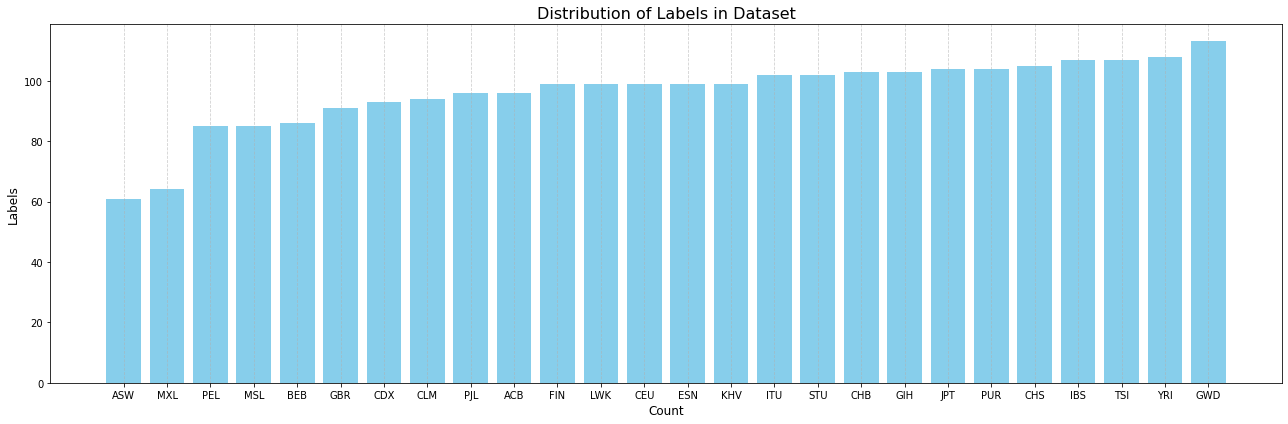

In [7]:
plot_label_distribution(pop_labels)

### Principal Component Analysis (PCA)

In [8]:
def apply_pca(train_df, test_df, n_components=None, explained_variance=None):

    if n_components is not None:
        pca = PCA(n_components=n_components, random_state=42)
    elif explained_variance is not None:
        pca = PCA(n_components=explained_variance, random_state=42)
    else:
        pca = PCA(random_state=42)
    
    principal_components_train = pca.fit_transform(train_df)
    principal_components_test = pca.transform(test_df)
    
    col_names = [f'PC{i+1}' for i in range(principal_components_train.shape[1])]
    
    pca_train_df = pd.DataFrame(data=principal_components_train, columns=col_names, index=train_df.index)
    pca_test_df  = pd.DataFrame(data=principal_components_test , columns=col_names, index=test_df.index)
    
    return pca_train_df, pca_test_df

### Singular Value Decomposition (SVD)

In [9]:
def apply_svd_numpy(df, n_components=100):

    centered_data = df - df.mean()
    
    U, s, Vt = np.linalg.svd(centered_data, full_matrices=False)  
    
    U_reduced  = U[:, :n_components]
    s_reduced  = s[:n_components]
    Vt_reduced = Vt[:n_components, :]

    reduced_data = np.dot(U_reduced, np.diag(s_reduced))
    
    col_names = [f'SVD{i+1}' for i in range(n_components)]
    svd_df = pd.DataFrame(data=reduced_data, columns=col_names, index= df.index)
    
    return svd_df

In [10]:
def apply_svd_sklearn(train_df, test_df, n_components=100):

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    
    principal_components_train = svd.fit_transform(train_df)
    principal_components_test  = svd.transform(test_df)
    
    col_names = [f'SVD{i+1}' for i in range(n_components)]
    
    svd_train_df = pd.DataFrame(data=principal_components_train, columns=col_names, index=train_df.index)
    svd_test_df  = pd.DataFrame(data=principal_components_test , columns=col_names, index=test_df.index)
    
    return svd_train_df, svd_test_df

### Random Forest 

In [11]:
def apply_rf_feature_selection(train_df, test_df, labels_df, num_features=None, importance_threshold=None):
    
    merged_df = train_df.merge(labels_df, left_index=True, right_on='Person_ID', how='left')
    
    data = merged_df.drop(columns=['Person_ID', 'labels'])
    labels = merged_df['labels']

    rf = RandomForestClassifier(random_state=42)
    rf.fit(data, labels)

    feature_importances = rf.feature_importances_

    if importance_threshold is not None:
        features_to_keep = train_df.columns[feature_importances >= importance_threshold]
    elif num_features is not None:
        sorted_features = train_df.columns[np.argsort(-feature_importances)]
        features_to_keep = sorted_features[:num_features]
    else:
        features_to_keep = train_df.columns

    rf_train_df = train_df[features_to_keep]
    rf_test_df  = test_df[features_to_keep]
    
    return rf_train_df, rf_test_df

### Normalization

In [12]:
def Normalizing(train_df, test_df):
    
    norm = train_df.columns
    
    train_val = train_df[norm]
    test_val  = test_df[norm]

    scaler = MinMaxScaler().fit(train_val.values)

    train_normalized = scaler.transform(train_val.values)
    test_normalized  = scaler.transform(test_val.values)

    train_df[norm] = train_normalized
    test_df[norm]  = test_normalized

    train_df = train_df.round(3)
    test_df  = test_df.round(3)
    
    return train_df, test_df

### Adding Label

In [13]:
def adding_label(train_df, test_df, labels_df, label_encoder):
    
    train_df = train_df.reset_index()
    test_df  = test_df.reset_index()
    
    train_df = train_df.merge(labels_df, on='Person_ID', how='left')
    test_df  = test_df.merge(labels_df , on='Person_ID', how='left')
    
    train_df['labels'] = label_encoder.transform(train_df['labels'])
    test_df['labels']  = label_encoder.transform(test_df['labels'])
    
    return train_df, test_df

### Apply Model

In [14]:
def apply_model(train_df, test_df, number_classes):
    
    X_train = train_df.drop(columns=['Person_ID', 'labels'])
    X_test  = test_df.drop(columns=[ 'Person_ID', 'labels'])
    y_train = train_df['labels']
    y_test  = test_df['labels']

    lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
    lr_model.fit(X_train, y_train)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train, y_train)

    lr_probabilities  = lr_model.predict_proba(X_test)
    xgb_probabilities = xgb_model.predict_proba(X_test)

    lr_results  = pd.DataFrame(lr_probabilities , columns=[f'Prob_Class_{i}' for i in range(0, number_classes)])
    xgb_results = pd.DataFrame(xgb_probabilities, columns=[f'Prob_Class_{i}' for i in range(0, number_classes)])

    lr_results['Person_ID']  = test_df['Person_ID'].values
    xgb_results['Person_ID'] = test_df['Person_ID'].values

    lr_results['True_Label'] = y_test.values
    xgb_results['True_Label']= y_test.values

    lr_results  = lr_results[[ 'Person_ID', 'True_Label'] + [f'Prob_Class_{i}' for i in range(0, number_classes)]]
    xgb_results = xgb_results[['Person_ID', 'True_Label'] + [f'Prob_Class_{i}' for i in range(0, number_classes)]]
    
    return lr_results, xgb_results

### Evaluation

In [15]:
def calculate_predicted_class(df, number_classes):
    
    predicted_labels = df[[f'Prob_Class_{i}' for i in range(0, number_classes)]].idxmax(axis=1)

    predicted_labels = predicted_labels.apply(lambda x: int(x.split('_')[-1]))
    true_labels = df['True_Label']
    
    return true_labels, predicted_labels

In [16]:
def calculate_performance_metrics(true_labels, predicted_labels, number_classes):
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels)
    evaluation_metrics_df = pd.DataFrame({'Class': [label_encoder.inverse_transform([i])[0] for i in range(0, number_classes)], 
                                          'Precision': precision,
                                          'Recall': recall,
                                          'F1-Score': f1_score})

    avg_recall = recall.mean()
    avg_precision= precision.mean()
    avg_f1_score = f1_score.mean()
    evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',
                                                          'Precision': avg_precision,
                                                          'Recall': avg_recall,
                                                          'F1-Score': avg_f1_score}, 
                                                           ignore_index=True)

    return evaluation_metrics_df

In [29]:
def plot_confusion_matrix(true_labels, predicted_labels, number_classes):
    
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=[label_encoder.inverse_transform([i])[0] for i in range(0, number_classes)], 
                                                       yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(0, number_classes)])
    plt.title('Confusion Matrix', fontsize=20)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [18]:
def plot_roc_curve(true_labels, df, number_classes):

    y_true = label_binarize(true_labels, classes=[i for i in range(0, number_classes)])
    n_classes = y_true.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], df[f'Prob_Class_{i}'])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), df[[f'Prob_Class_{i}' for i in range(0, number_classes)]].values.ravel())    
        
        
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'purple', 'orange']

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.3f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.3f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of {0} (area = {1:0.3f})'.format(label_encoder.inverse_transform([i])[0], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.00])
    plt.ylim([ 0.00, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro and Macro-Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()

### Cross Validation

In [19]:
number_of_components = 5000
classes = list(pop_labels.labels.unique())
number_classes = len(classes)

In [20]:
label_encoder = LabelEncoder()
label_encoder.fit(classes)

LabelEncoder()

In [21]:
X = pop_labels.drop(['labels'], axis=1)
y = pop_labels['labels']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
LR_PCA = []
LR_SVD = []
LR_RF  = []

XG_PCA = []
XG_SVD = []
XG_RF  = []

for train_index, test_index in skf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    train_data = result_df[result_df.index.isin(X_train.Person_ID)].copy()
    test_data  = result_df[result_df.index.isin(X_test.Person_ID)].copy()
    
    pca_train_df, pca_test_df = apply_pca(train_data, test_data, n_components=number_of_components, explained_variance=None)  
    svd_train_df, svd_test_df = apply_svd_sklearn(train_data, test_data, n_components=number_of_components)
    rf_train_df , rf_test_df  = apply_rf_feature_selection(train_data, test_data, pop_labels, num_features=number_of_components, importance_threshold=None)
    
    pca_train_df, pca_test_df = Normalizing(pca_train_df, pca_test_df)
    svd_train_df, svd_test_df = Normalizing(svd_train_df, svd_test_df)
    rf_train_df , rf_test_df  = Normalizing(rf_train_df , rf_test_df)
    
    pca_train_df, pca_test_df = adding_label(pca_train_df, pca_test_df, pop_labels, label_encoder)
    svd_train_df, svd_test_df = adding_label(svd_train_df, svd_test_df, pop_labels, label_encoder)
    rf_train_df , rf_test_df  = adding_label(rf_train_df , rf_test_df , pop_labels, label_encoder)
    
    lr_results_pca, xgb_results_pca = apply_model(pca_train_df, pca_test_df, number_classes)
    lr_results_svd, xgb_results_svd = apply_model(svd_train_df, svd_test_df, number_classes)
    lr_results_rf , xgb_results_rf  = apply_model(rf_train_df , rf_test_df , number_classes)
    
    LR_PCA.append(lr_results_pca)
    LR_SVD.append(lr_results_svd)
    LR_RF.append( lr_results_rf)
    
    XG_PCA.append(xgb_results_pca)
    XG_SVD.append(xgb_results_svd)
    XG_RF.append( xgb_results_rf)

/tmp/ipykernel_49770/1217525638.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[norm] = train_normalized
/tmp/ipykernel_49770/1217525638.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[norm]  = test_normalized
/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/tmp/ipykernel_49770/1217525638.py:13: SettingWithCopyWarning: 
A va

In [23]:
final_results_LR_PCA = pd.concat(LR_PCA, ignore_index=True)
final_results_LR_SVD = pd.concat(LR_SVD, ignore_index=True)
final_results_LR_RF  = pd.concat(LR_RF , ignore_index=True)

final_results_XG_PCA = pd.concat(XG_PCA, ignore_index=True)
final_results_XG_SVD = pd.concat(XG_SVD, ignore_index=True)
final_results_XG_RF  = pd.concat(XG_RF , ignore_index=True)

In [24]:
labels_LR_PCA, prediction_LR_PCA = calculate_predicted_class(final_results_LR_PCA, number_classes)
labels_LR_SVD, prediction_LR_SVD = calculate_predicted_class(final_results_LR_SVD, number_classes)
labels_LR_RF , prediction_LR_RF  = calculate_predicted_class(final_results_LR_RF , number_classes)

labels_XG_PCA, prediction_XG_PCA = calculate_predicted_class(final_results_XG_PCA, number_classes)
labels_XG_SVD, prediction_XG_SVD = calculate_predicted_class(final_results_XG_SVD, number_classes)
labels_XG_RF , prediction_XG_RF  = calculate_predicted_class(final_results_XG_RF , number_classes)

## LR - PCA

In [25]:
performance_LR_PCA = calculate_performance_metrics(labels_LR_PCA, prediction_LR_PCA, number_classes)
print(performance_LR_PCA)

      Class  Precision    Recall  F1-Score
0       ACB   0.680000  0.531250  0.596491
1       ASW   1.000000  0.114754  0.205882
2       BEB   1.000000  0.697674  0.821918
3       CDX   0.989130  0.978495  0.983784
4       CEU   0.655738  0.808081  0.723982
5       CHB   0.918605  0.766990  0.835979
6       CHS   0.771654  0.933333  0.844828
7       CLM   0.958763  0.989362  0.973822
8       ESN   0.829545  0.737374  0.780749
9       FIN   1.000000  1.000000  1.000000
10      GBR   0.710145  0.538462  0.612500
11      GIH   0.955556  0.834951  0.891192
12      GWD   0.982609  1.000000  0.991228
13      IBS   0.910891  0.859813  0.884615
14      ITU   0.729730  0.794118  0.760563
15      JPT   1.000000  1.000000  1.000000
16      KHV   0.989474  0.949495  0.969072
17      LWK   1.000000  1.000000  1.000000
18      MSL   1.000000  0.988235  0.994083
19      MXL   0.962963  0.812500  0.881356
20      PEL   0.977011  1.000000  0.988372
21      PJL   0.850000  0.885417  0.867347
22      PUR

/tmp/ipykernel_26466/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


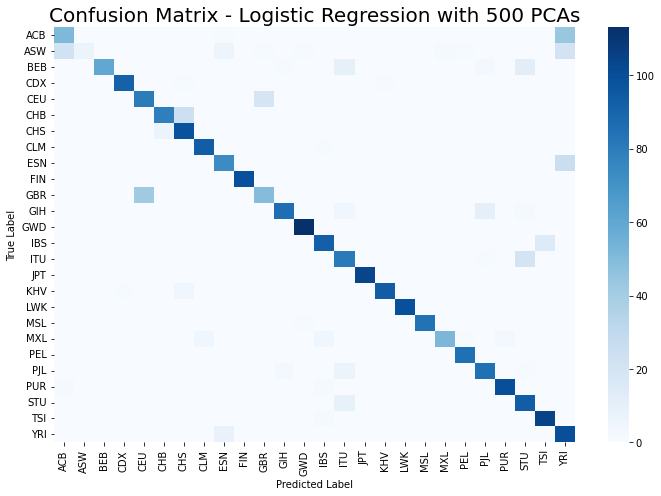

In [49]:
plot_confusion_matrix(labels_LR_PCA, prediction_LR_PCA, number_classes)

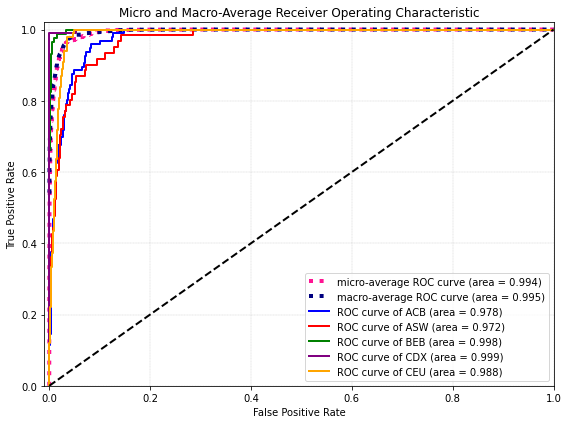

In [52]:
plot_roc_curve(labels_LR_PCA, final_results_LR_PCA, number_classes)

## LR - SVD

In [28]:
performance_LR_SVD = calculate_performance_metrics(labels_LR_SVD, prediction_LR_SVD, number_classes)
print(performance_LR_SVD)

      Class  Precision    Recall  F1-Score
0       ACB   0.666667  0.541667  0.597701
1       ASW   1.000000  0.114754  0.205882
2       BEB   1.000000  0.709302  0.829932
3       CDX   1.000000  0.978495  0.989130
4       CEU   0.632000  0.797980  0.705357
5       CHB   0.858696  0.766990  0.810256
6       CHS   0.760331  0.876190  0.814159
7       CLM   0.978947  0.989362  0.984127
8       ESN   0.833333  0.757576  0.793651
9       FIN   1.000000  1.000000  1.000000
10      GBR   0.676471  0.505495  0.578616
11      GIH   0.955556  0.834951  0.891192
12      GWD   0.991228  1.000000  0.995595
13      IBS   0.912621  0.878505  0.895238
14      ITU   0.745455  0.803922  0.773585
15      JPT   1.000000  1.000000  1.000000
16      KHV   0.989583  0.959596  0.974359
17      LWK   1.000000  1.000000  1.000000
18      MSL   1.000000  0.988235  0.994083
19      MXL   0.944444  0.796875  0.864407
20      PEL   0.955056  1.000000  0.977011
21      PJL   0.858586  0.885417  0.871795
22      PUR

/tmp/ipykernel_26466/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


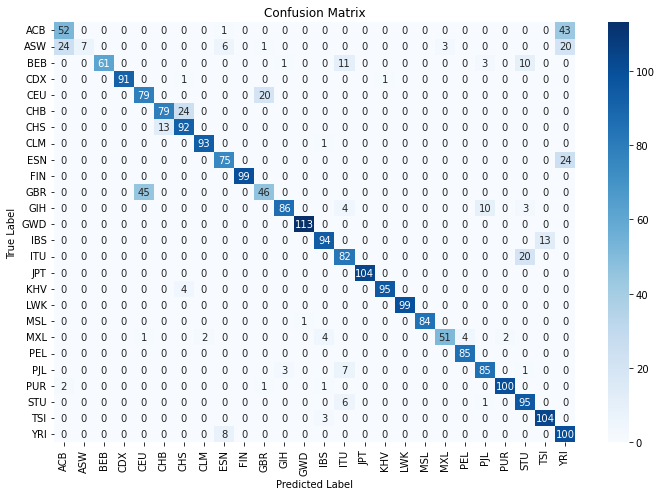

In [29]:
plot_confusion_matrix(labels_LR_SVD, prediction_LR_SVD, number_classes)

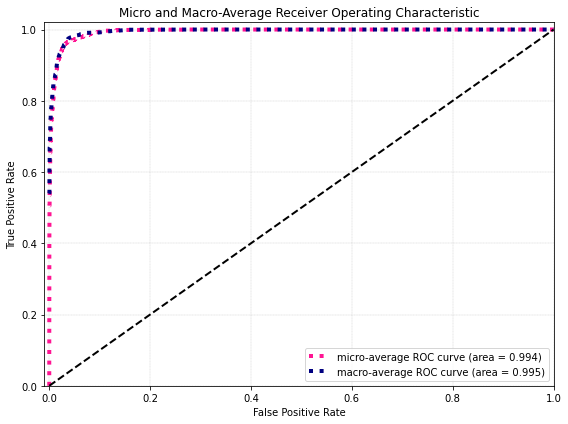

In [30]:
plot_roc_curve(labels_LR_SVD, final_results_LR_SVD, number_classes)

## LR - RF

In [25]:
performance_LR_RF = calculate_performance_metrics(labels_LR_RF , prediction_LR_RF, number_classes)
print(performance_LR_RF)

      Class  Precision    Recall  F1-Score
0       ACB   0.602410  0.520833  0.558659
1       ASW   0.913043  0.344262  0.500000
2       BEB   0.828125  0.616279  0.706667
3       CDX   0.870968  0.870968  0.870968
4       CEU   0.519231  0.545455  0.532020
5       CHB   0.621622  0.669903  0.644860
6       CHS   0.602041  0.561905  0.581281
7       CLM   0.936170  0.936170  0.936170
8       ESN   0.629921  0.808081  0.707965
9       FIN   0.990000  1.000000  0.994975
10      GBR   0.469136  0.417582  0.441860
11      GIH   0.844660  0.844660  0.844660
12      GWD   0.925620  0.991150  0.957265
13      IBS   0.750000  0.728972  0.739336
14      ITU   0.596639  0.696078  0.642534
15      JPT   1.000000  1.000000  1.000000
16      KHV   0.857143  0.848485  0.852792
17      LWK   0.990000  1.000000  0.994975
18      MSL   0.948718  0.870588  0.907975
19      MXL   0.962264  0.796875  0.871795
20      PEL   0.944444  1.000000  0.971429
21      PJL   0.813187  0.770833  0.791444
22      PUR

/tmp/ipykernel_49770/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


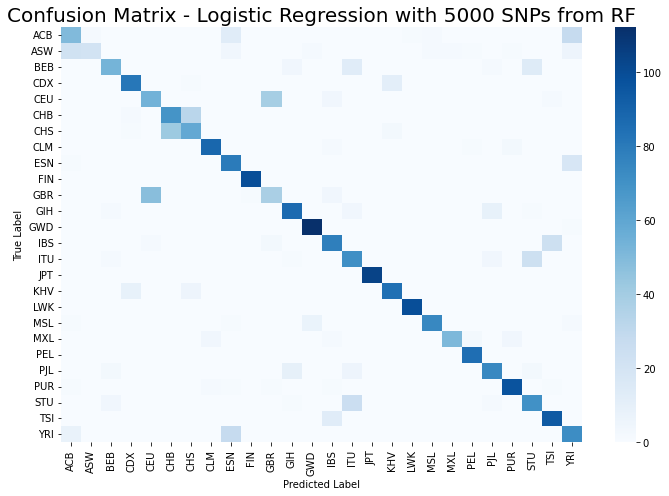

In [28]:
plot_confusion_matrix(labels_LR_RF , prediction_LR_RF, number_classes)

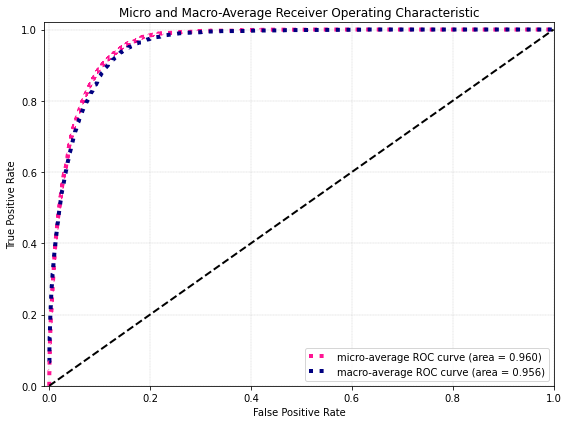

In [33]:
plot_roc_curve(labels_LR_RF, final_results_LR_RF, number_classes)

## XGB - PCA

In [34]:
performance_XG_PCA = calculate_performance_metrics(labels_XG_PCA, prediction_XG_PCA, number_classes)
print(performance_XG_PCA)

      Class  Precision    Recall  F1-Score
0       ACB   0.553571  0.645833  0.596154
1       ASW   0.591837  0.950820  0.729560
2       BEB   0.986301  0.837209  0.905660
3       CDX   0.300000  0.032258  0.058252
4       CEU   0.508380  0.919192  0.654676
5       CHB   0.807229  0.650485  0.720430
6       CHS   0.685484  0.809524  0.742358
7       CLM   0.860000  0.914894  0.886598
8       ESN   0.375000  0.060606  0.104348
9       FIN   1.000000  0.989899  0.994924
10      GBR   0.611111  0.120879  0.201835
11      GIH   0.860000  0.834951  0.847291
12      GWD   1.000000  0.796460  0.886700
13      IBS   0.523560  0.934579  0.671141
14      ITU   0.474860  0.833333  0.604982
15      JPT   1.000000  0.971154  0.985366
16      KHV   0.516129  0.969697  0.673684
17      LWK   1.000000  0.888889  0.941176
18      MSL   0.783019  0.976471  0.869110
19      MXL   0.872727  0.750000  0.806723
20      PEL   0.943820  0.988235  0.965517
21      PJL   0.783019  0.864583  0.821782
22      PUR

/tmp/ipykernel_26466/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


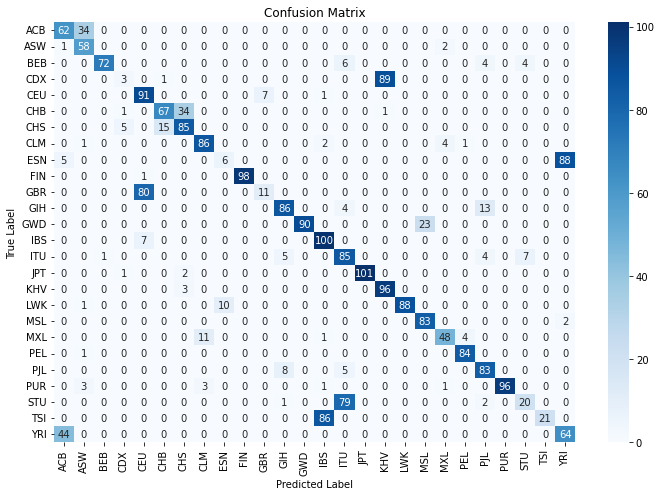

In [35]:
plot_confusion_matrix(labels_XG_PCA, prediction_XG_PCA, number_classes)

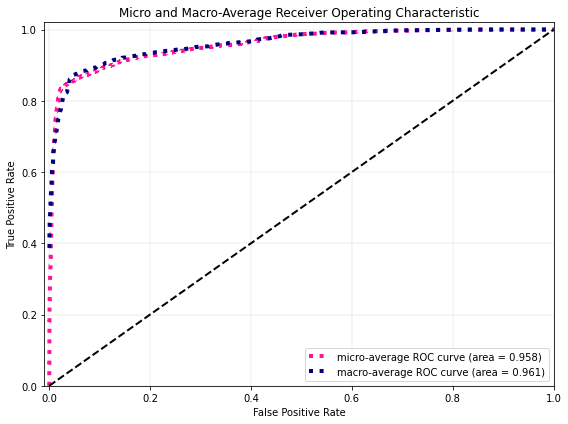

In [36]:
plot_roc_curve(labels_XG_PCA, final_results_XG_PCA, number_classes)

## XGB - SVD 

In [37]:
performance_XG_SVD = calculate_performance_metrics(labels_XG_SVD, prediction_XG_SVD, number_classes)
print(performance_XG_SVD)

      Class  Precision    Recall  F1-Score
0       ACB   0.539216  0.572917  0.555556
1       ASW   0.542857  0.934426  0.686747
2       BEB   0.961039  0.860465  0.907975
3       CDX   0.454545  0.053763  0.096154
4       CEU   0.524590  0.969697  0.680851
5       CHB   0.802326  0.669903  0.730159
6       CHS   0.704918  0.819048  0.757709
7       CLM   0.865979  0.893617  0.879581
8       ESN   0.285714  0.040404  0.070796
9       FIN   0.990000  1.000000  0.994975
10      GBR   0.727273  0.087912  0.156863
11      GIH   0.834951  0.834951  0.834951
12      GWD   1.000000  0.823009  0.902913
13      IBS   0.525773  0.953271  0.677741
14      ITU   0.502959  0.833333  0.627306
15      JPT   1.000000  0.971154  0.985366
16      KHV   0.521739  0.969697  0.678445
17      LWK   1.000000  0.888889  0.941176
18      MSL   0.805825  0.976471  0.882979
19      MXL   0.818182  0.703125  0.756303
20      PEL   0.923077  0.988235  0.954545
21      PJL   0.800000  0.833333  0.816327
22      PUR

/tmp/ipykernel_26466/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


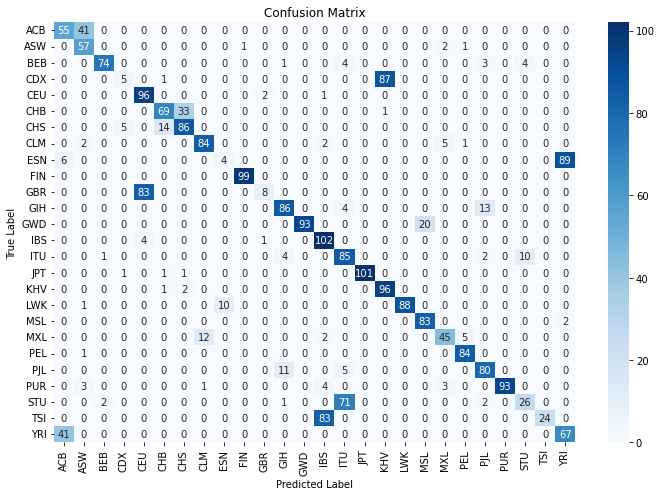

In [38]:
plot_confusion_matrix(labels_XG_SVD, prediction_XG_SVD, number_classes)

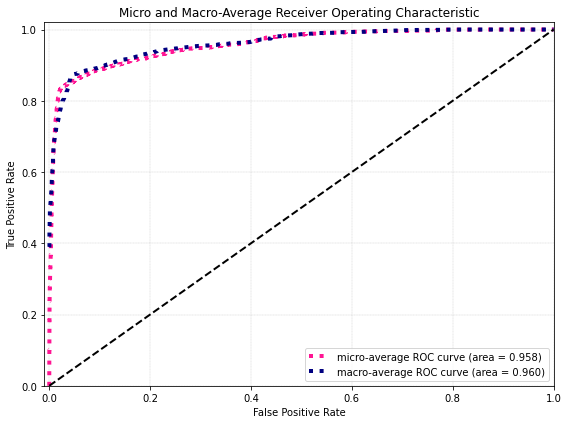

In [39]:
plot_roc_curve(labels_XG_SVD, final_results_XG_SVD, number_classes)

## XFB - RF

In [40]:
performance_XG_RF = calculate_performance_metrics(labels_XG_RF , prediction_XG_RF, number_classes)
print(performance_XG_RF)

      Class  Precision    Recall  F1-Score
0       ACB   0.250000  0.156250  0.192308
1       ASW   0.321429  0.147541  0.202247
2       BEB   0.347826  0.279070  0.309677
3       CDX   0.549451  0.537634  0.543478
4       CEU   0.302521  0.363636  0.330275
5       CHB   0.298077  0.300971  0.299517
6       CHS   0.318182  0.333333  0.325581
7       CLM   0.419753  0.361702  0.388571
8       ESN   0.350877  0.404040  0.375587
9       FIN   0.538462  0.494949  0.515789
10      GBR   0.231579  0.241758  0.236559
11      GIH   0.607843  0.601942  0.604878
12      GWD   0.537931  0.690265  0.604651
13      IBS   0.372727  0.383178  0.377880
14      ITU   0.287037  0.303922  0.295238
15      JPT   0.654206  0.673077  0.663507
16      KHV   0.467391  0.434343  0.450262
17      LWK   0.560440  0.515152  0.536842
18      MSL   0.350000  0.329412  0.339394
19      MXL   0.425926  0.359375  0.389831
20      PEL   0.752809  0.788235  0.770115
21      PJL   0.401961  0.427083  0.414141
22      PUR

/tmp/ipykernel_26466/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


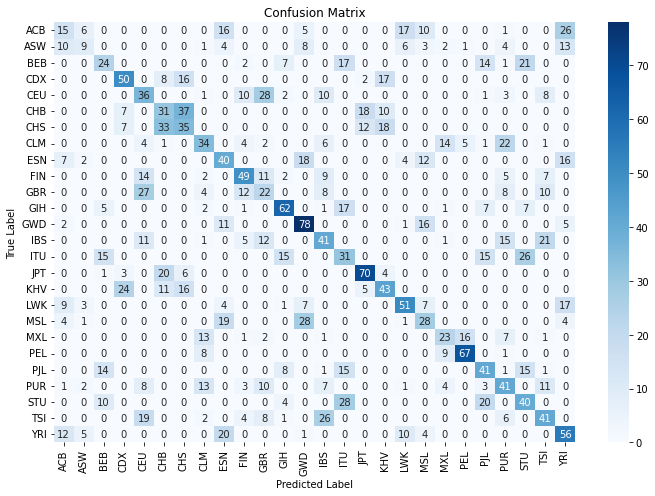

In [41]:
plot_confusion_matrix(labels_XG_RF , prediction_XG_RF, number_classes)

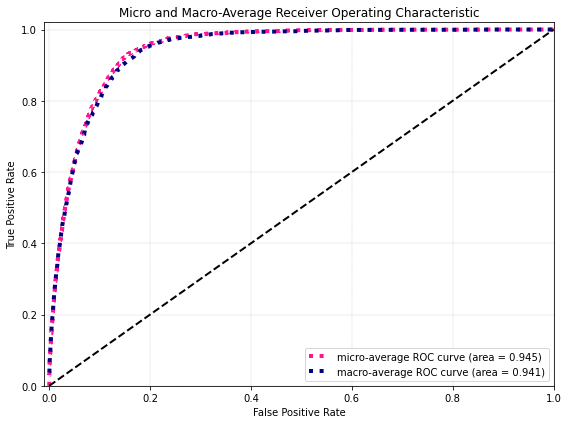

In [42]:
plot_roc_curve(labels_XG_RF, final_results_XG_RF, number_classes)